In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [9]:
with open('StatisticsResults/friday_0_survival_preparedness_Relocate_Workload_0.4_NoUber.pickle', 'rb') as f:
    statistics = pickle.load(f)

In [ ]:
def visualizeSpatialStatistic(ax, shp):
    pass

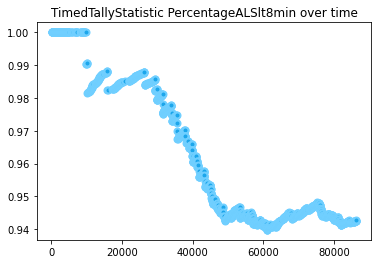

In [10]:
statistics[0]['PercentageALSlt8min'].visualize()

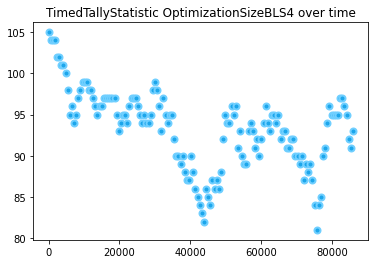

In [4]:
statistics[0]['OptimizationSizeBLS4'].visualize()

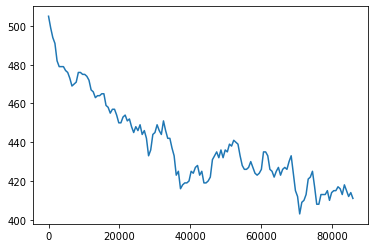

In [5]:
#[d[1] for S in [statistics[0]['OptimizationSizeALS{}'.format(i)] for i in range(1,6)] for d in S.data]
plt.plot([data[0] for data in statistics[0]['OptimizationSizeBLS1'].data],
[sum(d[1] for S in [statistics[0]['OptimizationSizeBLS{}'.format(i)] for i in range(1,6)] for d in S.data if d[0] == data[0]) for data in statistics[0]['OptimizationSizeBLS1'].data])

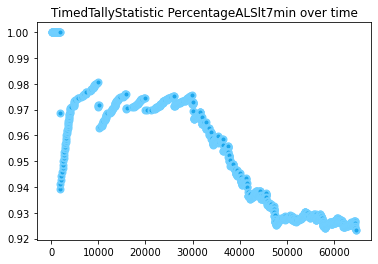

In [112]:
statistics[0]['PercentageALSlt7min'].visualize()

(array([ 42.,  25.,  35.,  38.,  57.,  76.,  71.,  89.,  86.,  95., 102.,
         89., 116., 107.,  94.,  86., 103.,  84.,  81.,  66.,  73.,  66.,
         77.,  71.,  79.,  73.,  82.,  72.,  76.,  72.,  78.,  77.,  69.,
         12.,   4.,   6.,   7.,   1.,   4.,   1.,   3.,   1.,   2.,   3.,
          1.,   1.,   3.,   1.,   2.,   0.,   2.,   1.,   3.,   2.,   0.,
          2.,   0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([   0.        ,   14.55520018,   29.11040036,   43.66560055,
          58.22080073,   72.77600091,   87.33120109,  101.88640127,
         116.44160145,  130.99680164,  145.55200182,  160.107202  ,
         174.66240218,  189.21760236,  203.77280254,  218.32800273,
         232.88320291,  247.43840309,  261.993

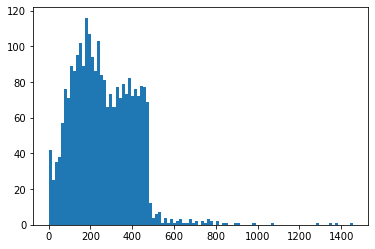

In [115]:
plt.hist([d[1] for d in statistics[0]['TravelTime'].data], bins = 100)

In [86]:
np.array([d[1] for d in statistics[0]['TravelTime'].data]).mean()

291.14943948489235

(array([11.,  9., 19., 18., 27., 43., 70., 69., 56., 60., 76., 73., 74.,
        93., 81., 70., 74., 61., 93., 69., 71., 56., 55., 58., 53., 47.,
        47., 36., 44., 41., 36., 27., 21., 23., 19., 19., 12., 17., 12.,
         8., 12., 11.,  9.,  6.,  4.,  6.,  3.,  5.,  3.,  2.,  2.,  1.,
         1.,  2.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
         0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,  3.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([  10.34417482,   31.86692052,   53.38966623,   74.91241193,
          96.43515763,  117.95790334,  139.48064904,  161.00339475,
         182.52614045,  204.04888615,  225.57163186,  247.09437756,
         268.61712326,  290.13986897,  311.66261467,  333.18536038,
         354.70810608,  376.23085178,  397.75359749,  419.27634319,
         440.7990889 ,  462.3218346 ,  483.8445803 ,  505.36732601,
         526.89007171,  54

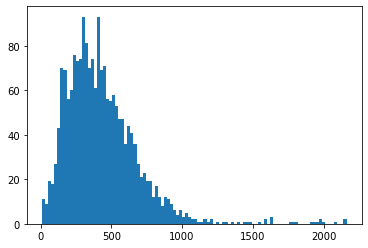

In [72]:
plt.hist([d[1] for d in statistics[0]['ToHospitalTime'].data], bins = 100)

In [87]:
np.array([d[1] for d in statistics[0]['ToHospitalTime'].data]).mean()

432.6503422684321

(array([21., 47., 70., 99., 66., 47., 74., 75., 50.,  8.,  5., 15.,  7.,
         7., 16., 17., 19., 21., 28., 28., 37., 43., 37., 46., 55., 47.,
        59., 58., 68., 65., 65., 61., 65., 53., 61., 59., 60., 54., 43.,
        42., 58., 56., 50., 35., 35., 33., 32., 39., 28., 31., 19., 37.,
        20., 23., 15., 16., 25., 15., 16.,  9.,  8.,  5.,  7., 11.,  4.,
         8.,  4.,  9.,  8., 10.,  3.,  2.,  3.,  1.,  6.,  5.,  3.,  2.,
         3.,  2.,  1.,  1.,  3.,  2.,  1.,  1.,  2.,  0.,  0.,  0.,  2.,
         1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([   0.        ,   54.00379827,  108.00759655,  162.01139482,
         216.0151931 ,  270.01899137,  324.02278965,  378.02658792,
         432.0303862 ,  486.03418447,  540.03798275,  594.04178102,
         648.04557929,  702.04937757,  756.05317584,  810.05697412,
         864.06077239,  918.06457067,  972.06836894, 1026.07216722,
        1080.07596549, 1134.07976377, 1188.08356204, 1242.08736031,
        1296.09115859, 135

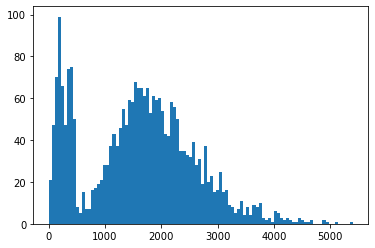

In [116]:
plt.hist([d for d in statistics[0]['EmergenciesTimeInSystem'].data], bins = 100)

(array([ 4.,  8., 11., 14., 16., 33., 40., 37., 41., 43., 40., 47., 49.,
        50., 57., 62., 46., 52., 53., 54., 57., 62., 57., 59., 63., 75.,
        50., 54., 56., 50., 60., 41., 34., 43., 35., 33., 34., 28., 28.,
        26., 25., 19., 17., 18., 18., 16., 18., 16., 13., 11., 11., 10.,
         6.,  9.,  5., 13., 13.,  5.,  7.,  6.,  4.,  9.,  3.,  2.,  1.,
         6.,  2.,  1.,  2.,  1.,  3.,  1.,  1.,  2.,  1.,  0.,  1.,  0.,
         1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  84.97548258,  132.28379012,  179.59209766,  226.90040519,
         274.20871273,  321.51702027,  368.8253278 ,  416.13363534,
         463.44194288,  510.75025042,  558.05855795,  605.36686549,
         652.67517303,  699.98348056,  747.2917881 ,  794.60009564,
         841.90840317,  889.21671071,  936.52501825,  983.83332578,
        1031.14163332, 1078.44994086, 1125.75824839, 1173.06655593,
        1220.37486347, 126

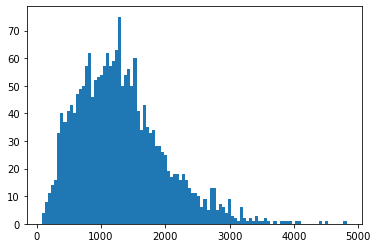

In [75]:
plt.hist([d[1] for d in statistics[0]['LSAttentionTime'].data + statistics[0]['HSAttentionTime'].data if d[1] > 0], bins = 100)

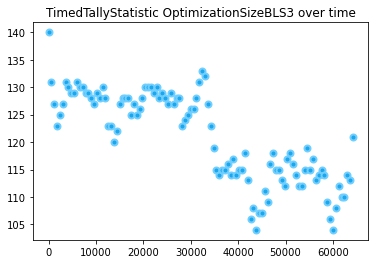

In [117]:
statistics[0]['OptimizationSizeBLS3'].visualize()

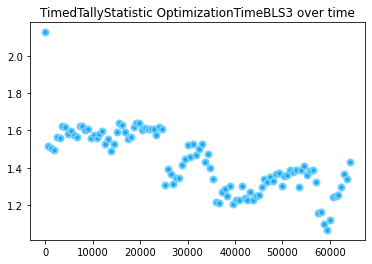

In [118]:
statistics[0]['OptimizationTimeBLS3'].visualize()

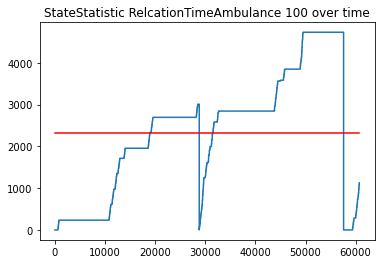

In [120]:
statistics[1]['Ambulance 100']['RelocationTime'].visualize()

In [107]:
statistics[0]['EmergenciesServed'].data

1944